## Extra models

Two extra models are considered:

- Linear regression using a `QuanttileTransformer` to make target data more gaussian like 
- A Multi-Layer perceptron Neural Network


In [1]:
%matplotlib notebook
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import  TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import ElasticNet
from sklearn.metrics import r2_score, median_absolute_error
from sklearn.compose import TransformedTargetRegressor
from sklearn.preprocessing import QuantileTransformer

from utils import *
df_hour = pd.read_csv("hour.csv")

In [2]:
# adding 3h and 1w features
names = []
for i,name in [ (3,"3h") ,(24*7,"1w")]:
    %%time df_hour[name]= df_hour["instant"].apply(lambda x: aggregate_last_n_hours(df_hour,x,i)  )
    names.append(name)

Wall time: 1.52 s
Wall time: 1min 31s


In [31]:
preliminary_features = ["season","mnth","hr","holiday","weekday","workingday","weathersit","temp","hum","windspeed","cnt"]
df = df_hour[ preliminary_features + names ]

In [32]:
#encoding categorical
categorical2encode = ["season","mnth","hr","weekday","weathersit"]
df = one_hot_encode(df,categorical2encode)

Number of model features after one-hot encoding: 58


In [33]:
# train test split
X_train, y_train, X_test, y_test = split_train_test(df,fraction_train=0.8)

In [34]:
# scaling 1w and 3h using MinMaxScaler fitted to training data. Test data not used to avoide leakage 
scalers = {}
for name in ["3h","1w"]:
    scaler = MinMaxScaler()
    feature_name = name+"_scaled"
    X_train[feature_name]=scaler.fit_transform( X_train[name].values.reshape(-1, 1) )   
    X_train = X_train.drop(columns=name)
    scalers[name] = scaler

c:\users\c.lizarazosabogal\appdata\local\programs\python\python35\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [35]:
#transforming test set for predictions
for name in ["3h","1w"]:
    feature_name = name+"_scaled"
    X_test[feature_name] = scalers[name].transform( X_test[name].values.reshape(-1, 1) )   
    X_test = X_test.drop(columns=name)

c:\users\c.lizarazosabogal\appdata\local\programs\python\python35\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [36]:
# definning split for forward-validation
n_splits=5
tscv = TimeSeriesSplit(n_splits=n_splits)

### Linear Regression with Transformed Target for Lognorm distributions

In [37]:
model = ElasticNet(max_iter=3000,tol=1e-5)
# training and hyper-parameter optimization:
### log-transformation of target
qt = QuantileTransformer(output_distribution='normal', random_state=0)
qt.fit(y_train.values.reshape(-1, 1))
regr_trans = TransformedTargetRegressor(regressor=ElasticNet(),transformer=qt)
##sub-space of hyper-parameters:
parameters = {'alpha':[1e-3,5e-3,1e-2,5e-2,1e-1,1,5], 'l1_ratio':[0.05,0.25,0.5,0.75,1.0]}
parameters_logtarget = {'regressor__alpha':parameters["alpha"], 'regressor__l1_ratio': parameters["l1_ratio"]}
clf_lognormtarget = GridSearchCV(regr_trans, parameters_logtarget, cv=tscv,scoring="neg_mean_absolute_error",n_jobs=-1)
%time clf_lognormtarget.fit(X_train,y_train)

Wall time: 7.91 s


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
       error_score='raise-deprecating',
       estimator=TransformedTargetRegressor(check_inverse=True, func=None, inverse_func=None,
              regressor=ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol...=False, n_quantiles=1000,
          output_distribution='normal', random_state=0, subsample=100000)),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'regressor__l1_ratio': [0.05, 0.25, 0.5, 0.75, 1.0], 'regressor__alpha': [0.001, 0.005, 0.01, 0.05, 0.1, 1, 5]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_absolute_error', verbose=0)

<IPython.core.display.Javascript object>


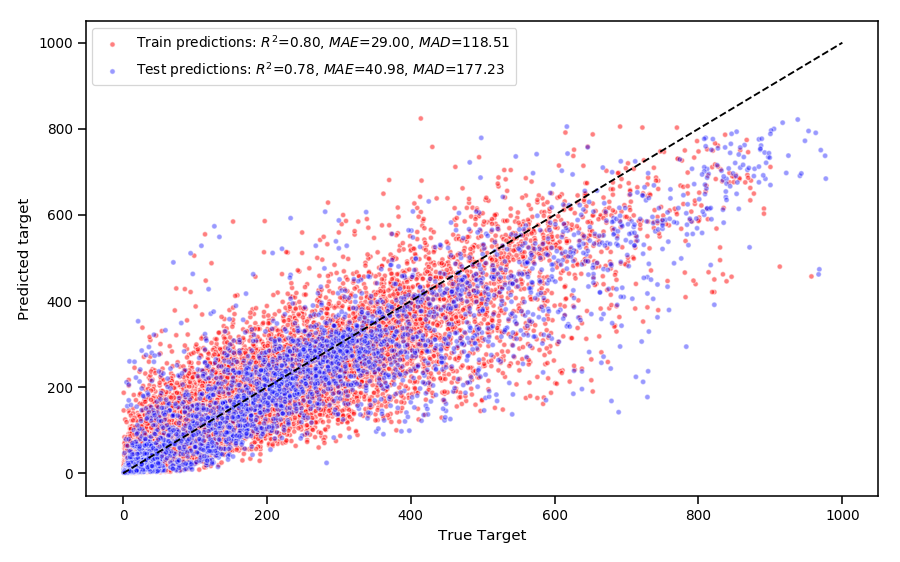

In [38]:
sns.set_context("paper")
y_train_pred = clf_lognormtarget.predict(X_train) 
y_test_pred = clf_lognormtarget.predict(X_test)
saveplot="error_on_test_set"
compare_predictions_vs_true(y_train_pred,y_train,y_test_pred,y_test)#,saveplot)

<IPython.core.display.Javascript object>


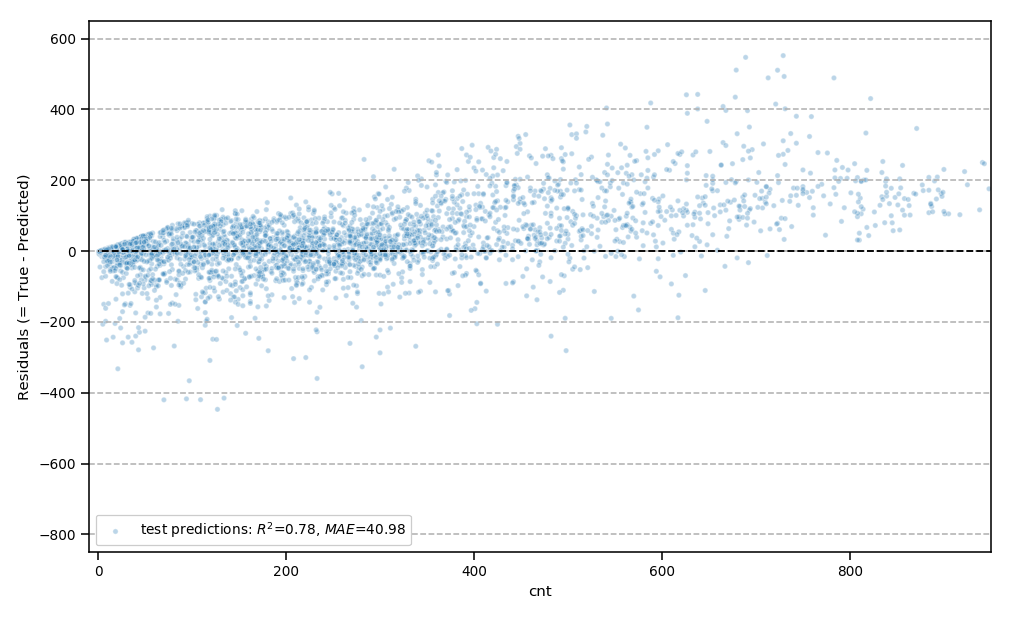

In [39]:
sns.set_context("paper")
residuals_predictions = plot_residuals(y_test,{"test predictions":y_test_pred}, saveplot="")

<IPython.core.display.Javascript object>


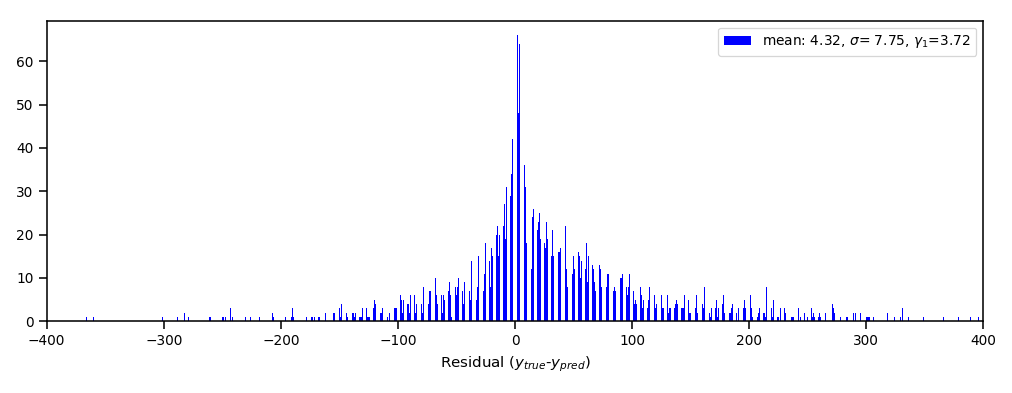

In [40]:
res_bins = residuals_distribution(residuals_predictions)

## NN Regressor (Multi-Layer perceptron)

In [19]:
from sklearn.neural_network import MLPRegressor
nn_regressor= MLPRegressor(activation='relu',random_state=0)

parameters = {'alpha':[5e-5,1e-4,5e-4,1e-3],'hidden_layer_sizes':[(12,12),(10,10,10),(10,8,8,5)],'max_iter':[200,300,400]}
clf_nnreg = GridSearchCV(nn_regressor, parameters, cv=tscv,scoring="r2",n_jobs=-1)
%time clf_nnreg.fit(X_train,y_train)
#nn_regressor.fit(X_train,y_train)

Wall time: 6min 9s


c:\users\c.lizarazosabogal\appdata\local\programs\python\python35\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
       error_score='raise-deprecating',
       estimator=MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=0, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'alpha': [5e-05, 0.0001, 0.0005, 0.001], 'hidden_layer_sizes': [(12, 12), (10, 10, 10), (10, 8, 8, 5)], 'max_iter': [200, 300, 400]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='r2', verbose=0)

In [20]:
clf_nnreg.best_params_

{'alpha': 0.001, 'hidden_layer_sizes': (10, 10, 10), 'max_iter': 400}

<IPython.core.display.Javascript object>


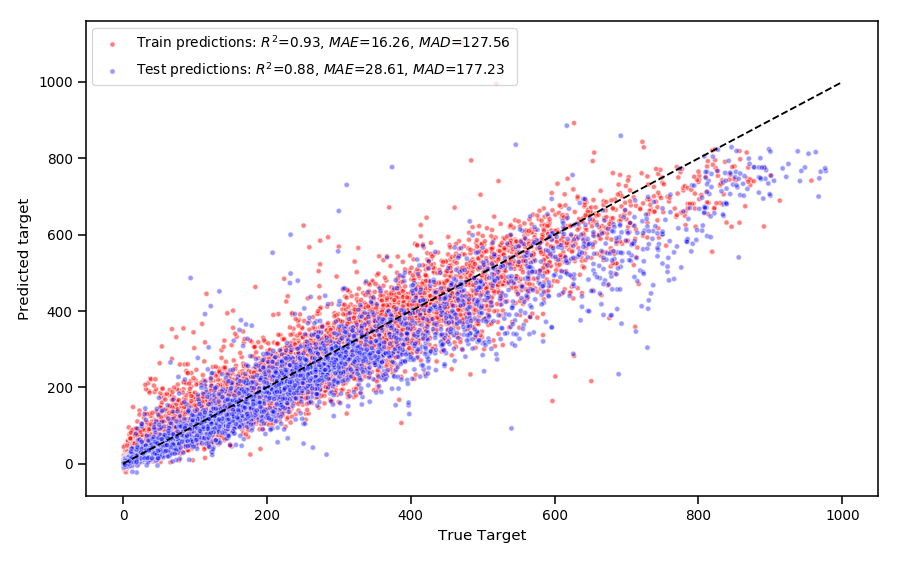

In [23]:
y_train_pred = clf_nnreg.predict(X_train) 
y_test_pred = clf_nnreg.predict(X_test)
compare_predictions_vs_true(y_train_pred,y_train,y_test_pred,y_test)#,saveplot)

<IPython.core.display.Javascript object>


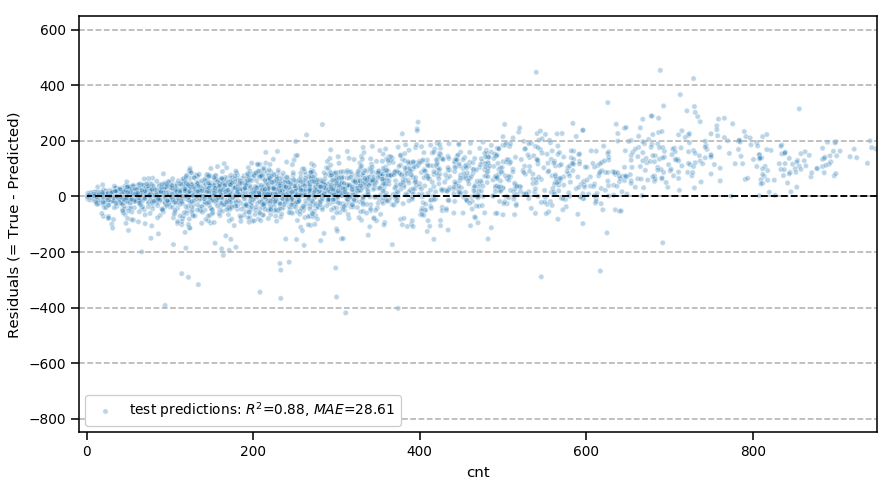

In [22]:
sns.set_context("paper")
residuals_predictions = plot_residuals(y_test,{"test predictions":y_test_pred}, saveplot="")

<IPython.core.display.Javascript object>


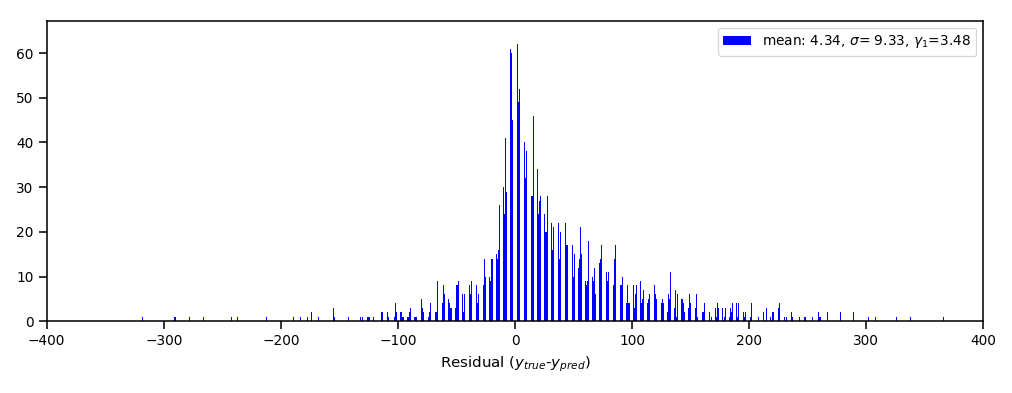

In [24]:
res_bins = residuals_distribution(residuals_predictions)